In [38]:
import yaml
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col, regexp_replace, udf, col, count, expr, row_number, regexp_replace, when, corr
from pyspark.sql.types import IntegerType, StringType, DoubleType
from textblob import TextBlob
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import pandas as pd

In [39]:
# Initialize a Spark session
spark = SparkSession.builder.appName("DataTransformation")\
    .config('spark.driver.extraClassPath','/usr/lib/jvm/java-11-openjdk-amd64/lib/postgresql-42.5.0.jar')\
        .getOrCreate()

In [40]:
# Define the path to your YAML file
yaml_file_path = 'config.yaml'

# Read the YAML file and parse it into a Python dictionary
with open(yaml_file_path, 'r') as yaml_file:
    config = yaml.safe_load(yaml_file)

In [41]:
listing_df_raw = spark.read.csv('raw_data/listings.tsv', header=True, inferSchema=True, sep="\t")
reviews_df_raw = spark.read.csv('raw_data/reviews.tsv', header=True, inferSchema=True, sep="\t")
calendar_df_raw = spark.read.csv('raw_data/calendar.tsv', header=True, inferSchema=True,sep="\t")

In [42]:
# Data Cleaning
listing_df_raw = listing_df_raw.drop('summary')
listing_df_raw = listing_df_raw.drop('description')
listing_df_raw = listing_df_raw.drop('host_about')

listing_df_raw = listing_df_raw.withColumn('host_is_superhost', when(col('host_is_superhost') == 't', True).otherwise(False))
listing_df_raw = listing_df_raw.drop('country', 'market')
listing_df_raw = listing_df_raw.na.drop(subset=['space'])
listing_df_raw = listing_df_raw.na.drop(subset=['property_type'])
listing_df_raw = listing_df_raw.withColumn("price", regexp_replace(col("price"), "[^0-9]", "").cast(IntegerType()))
listing_df_raw = listing_df_raw.withColumn("host_response_rate", regexp_replace(col("host_response_rate"), "%", "").cast("int"))

for column in listing_df_raw.columns:
    listing_df_raw = listing_df_raw.withColumn(column, regexp_replace(col(column), ',', '')) 

calendar_df_raw = calendar_df_raw.withColumn('available', when(col('available') == 't', True).otherwise(False))
calendar_df_raw = calendar_df_raw.withColumn("price", regexp_replace(col("price"), "[^0-9]", "").cast(IntegerType()))

In [43]:
#saving the data locally in parquet format
listing_df_raw.coalesce(4).write.parquet('cleaned_data/clean_listing_parquet', mode="overwrite", compression="snappy")
calendar_df_raw.coalesce(4).write.parquet('cleaned_data/clean_calendar_parquet', mode="overwrite", compression="snappy")
reviews_df_raw.coalesce(4).write.parquet('cleaned_data/clean_reviews_parquet', mode="overwrite", compression="snappy")

In [44]:
#load data to postgres

listing_df_raw.write.format('jdbc').options(url='jdbc:postgresql://localhost:5432/Final',driver = 'org.postgresql.Driver', dbtable = 'listing', user=config['postgres']["user"],password=config['postgres']["password"] ).mode('overwrite').save()
calendar_df_raw.write.format('jdbc').options(url='jdbc:postgresql://localhost:5432/Final',driver = 'org.postgresql.Driver', dbtable = 'calendar', user=config['postgres']["user"],password=config['postgres']["password"] ).mode('overwrite').save()
reviews_df_raw.write.format('jdbc').options(url='jdbc:postgresql://localhost:5432/Final',driver = 'org.postgresql.Driver', dbtable = 'reviews', user=config['postgres']["user"],password=config['postgres']["password"] ).mode('overwrite').save()

In [45]:
#reading the file back from postgres
listing_df = spark.read.format('jdbc').options(url='jdbc:postgresql://localhost:5432/Final',driver = 'org.postgresql.Driver', dbtable = 'listing', user=config['postgres']["user"],password=config['postgres']["password"]).load()
calendar_df = spark.read.format('jdbc').options(url='jdbc:postgresql://localhost:5432/Final',driver = 'org.postgresql.Driver', dbtable = 'calendar', user=config['postgres']["user"],password=config['postgres']["password"]).load()
reviews_df = spark.read.format('jdbc').options(url='jdbc:postgresql://localhost:5432/Final',driver = 'org.postgresql.Driver', dbtable = 'reviews', user=config['postgres']["user"],password=config['postgres']["password"]).load()

## Task 1 Get Distinct Street names and it's best listing based on analysis of price, reviews and booking. Give the budget oriented results and luxury oriented results

In [54]:
#firstly lets calculate reviews rating by using sentiment analysis
# Define a function to perform sentiment analysis using TextBlob
def analyze_sentiment(comment):
    if comment is not None and isinstance(comment, str):
        analysis = TextBlob(comment)
        # Classify sentiment as positive, neutral, or negative based on polarity
        if analysis.sentiment.polarity > 0:
            return "positive"
        elif analysis.sentiment.polarity == 0:
            return "neutral"
        else:
            return "negative"
    else:
        return None
    
# Register the UDF
sentiment_analysis_udf = udf(analyze_sentiment, StringType())

# analyze the sentiment of review and keep it under sentiment column in a new df
reviews_sentiment = reviews_df.withColumn("sentiment", sentiment_analysis_udf(col("comments")))

#returned the count of total postitive reviews got by a listing id
reviews_sentiment1 = reviews_sentiment.groupBy("listing_id")\
    .agg(count(col("sentiment")=="positive"). alias("total_positive_reviews"), count("*").alias("total_reviews_count"))

#added a new column review_rate 
final_review = reviews_sentiment1\
    .withColumn("Review_rate", col("total_positive_reviews")/col("total_reviews_count"))

#dropped irrelevant columns adn now REVIEW DATAFRAME is ready
final_review = final_review.drop('total_positive_reviews', 'total_reviews_count')

#Now I listed total days each property was booked for from calendar
calendar_1 = calendar_df.groupBy("listing_id")\
    .agg(count(expr("CASE WHEN available = False THEN 1 ELSE NULL END")).alias("booked_days"))

#we used MinMaxScaler to normalize the data and it expects the input column to be of vector type
#thus we convert booked_days to vector format by using VectorAssembler
vector_assembler = VectorAssembler(inputCols=["booked_days"], outputCol="booked_days_vec")
calendar_1 = vector_assembler.transform(calendar_1)

#normalization is done here. MinMaxScaler normalizes the values from 1 to 0
scaler = MinMaxScaler(inputCol="booked_days_vec", outputCol="normalized_booked_days")

scaler_model = scaler.fit(calendar_1)
normalized_calendar = scaler_model.transform(calendar_1)

#creating a function to convert vector type to double type
unlist = udf(lambda x: float(list(x)[0]), DoubleType())

#adding new column returned as normalized value in regular double form
normalized_calendar = normalized_calendar.withColumn("nbd_new", unlist("normalized_booked_days"))

#defining final calendar dataframe where we have listing_id and booked days
final_calendar = normalized_calendar.select("listing_id", col("nbd_new").alias("booked_days"))

#now for the final dataframe
listing1 = listing_df.select("id", "name", "street", "property_type", "price")
listing1 = listing1.withColumn("price", col("price").cast("int"))

#converting the price to vector form for normalization
vector_assembler1 = VectorAssembler(inputCols=["price"], outputCol="price_vec")
listing1 = vector_assembler1.transform(listing1)

#normalizing the value to fall between range of 0 and 1
scaler1 = MinMaxScaler(inputCol="price_vec", outputCol="lux_price_vec")

scaler_model1 = scaler1.fit(listing1)
normalized_listing = scaler_model1.transform(listing1)

#converting vector type back to double using the unlist function
normalized_listing = normalized_listing.withColumn("lux_price", unlist("lux_price_vec"))

#dropping irrelevant columns
normalized_listing = normalized_listing.drop('price_vec', 'lux_price_vec')

#creating a new column with a new metric budget price which is luxury price subtracted from 1
final_listing = normalized_listing.withColumn("bud_price", 1-col("lux_price"))

#joining 2 of the 3 dataframes we have
#I preffered inner join as that would optimize resources considerably
ini_join = final_review.join(final_calendar, "listing_id")

#now joining the remaining dataframe
final_join = final_listing.join(ini_join, final_listing["id"] == ini_join["listing_id"])

#dropping redundant columns
final_join = final_join.drop('listing_id')

#calculating overall score based on the budget price
final_join_bud = final_join.withColumn("Overal_score", (10*col("bud_price"))+col("Review_rate")+col("booked_days"))
final_join_bud1 = final_join_bud.drop('lux_price', 'bud_price', 'Review_rate', 'booked_days')
#partitioning by street name and sorting by decreasing order of the overall score
windowSpec = Window.partitionBy("street").orderBy(col("Overal_score").desc())

#implementing window functon
final_join_bud2 = final_join_bud1.withColumn("position", row_number().over(windowSpec))

#calculating overall score based on the luxury price
final_join_lux = final_join.withColumn("Overal_score", col("lux_price")+col("Review_rate")+col("booked_days"))

#dropping irrelevant columns
final_join_lux1 = final_join_lux.drop('lux_price', 'bud_price', 'Review_rate', 'booked_days')

#implementing window function
final_join_lux2 = final_join_lux1.withColumn("position", row_number().over(windowSpec))

#displaying results
print("Sorted on the basis of budget:")
final_join_bud2.show()
print("Sorted on the basis of luxury")
final_join_lux2.show()

#pushing the results back to a new database in postgres
final_join_lux2.write.format('jdbc').options(url='jdbc:postgresql://localhost:5432/Result',driver = 'org.postgresql.Driver', dbtable = 'luxury_results', user=config['postgres']["user"],password=config['postgres']["password"]).mode('overwrite').save()
final_join_bud2.write.format('jdbc').options(url='jdbc:postgresql://localhost:5432/Result',driver = 'org.postgresql.Driver', dbtable = 'budget_results', user=config['postgres']["user"],password=config['postgres']["password"]).mode('overwrite').save()

Sorted on the basis of budget:


+--------+--------------------+--------------------+-------------+-----+------------------+--------+
|      id|                name|              street|property_type|price|      Overal_score|position|
+--------+--------------------+--------------------+-------------+-----+------------------+--------+
| 8454985|Modern Navy Yard ...|13th St Charlesto...|    Apartment|22500|10.844573745922595|       1|
| 2167993|Boston Waterfront...|13th Street Bosto...|    Apartment|14900|10.739037291721766|       1|
|12915510|It's always more ...|13th Street Bosto...|         Boat|22900|10.474874371859297|       2|
| 5684598|Navy Yard Condo o...|1st Avenue Boston...|    Apartment|19900|10.755514414176144|       1|
| 5481243|Private room in B...|1st Avenue Charle...|  Condominium|15000|10.783893149960328|       1|
| 4532603|Heart of Boston -...|A Garden St Bosto...|    Apartment|22900| 10.59241823150842|       1|
|14536322|Victorian Garden ...|A Mount Auburn St...|        House| 8500|10.924402715331041|

+--------+--------------------+--------------------+-------------+-----+------------------+--------+
|      id|                name|              street|property_type|price|      Overal_score|position|
+--------+--------------------+--------------------+-------------+-----+------------------+--------+
| 8454985|Modern Navy Yard ...|13th St Charlesto...|    Apartment|22500|1.4111566604954597|       1|
| 2167993|Boston Waterfront...|13th Street Bosto...|    Apartment|14900|1.0955699550383495|       1|
|12915510|It's always more ...|13th Street Bosto...|         Boat|22900|1.0525125628140704|       2|
| 5684598|Navy Yard Condo o...|1st Avenue Boston...|    Apartment|19900| 1.250238032266596|       1|
| 5481243|Private room in B...|1st Avenue Charle...|  Condominium|15000|1.1431896323723882|       1|
| 4532603|Heart of Boston -...|A Garden St Bosto...|    Apartment|22900| 1.170056422463193|       1|
|14536322|Victorian Garden ...|A Mount Auburn St...|        House| 8500|1.1040509565370713|

## Task 2: Analyze the impact of host response time on guest satisfaction. Correlate faster response time with higher review scores. Determine if host with high turnover consistently provide quicker response.

Table that shows response time score and reviews:


+--------+--------------+-----------+
|      id|response_score|Review_rate|
+--------+--------------+-----------+
|10036037|           294|        1.0|
|14219033|           400|        1.0|
| 7825327|           400|        1.0|
| 2754975|           400|        1.0|
| 6911945|           300|        1.0|
| 3068453|           282|        1.0|
| 8036024|           400|        1.0|
| 1615033|           400|        1.0|
| 4149974|           400|        1.0|
| 8303267|           300|        1.0|
| 1912940|           300|        1.0|
| 8310653|          null|        1.0|
| 8822499|           270|        1.0|
| 3873776|            14|        1.0|
|13251243|           400|        1.0|
|  197972|           400|        1.0|
|13602808|           400|        1.0|
|  321328|           120|        1.0|
| 8814215|           400|        1.0|
| 6596242|           300|        1.0|
+--------+--------------+-----------+
only showing top 20 rows



Correlation Coefficient: 0.006623173825858055
The key takeaway from this is that, apart from response score other factors affect the review rate as well. Such as cleaniness, price point, amneties, etc.


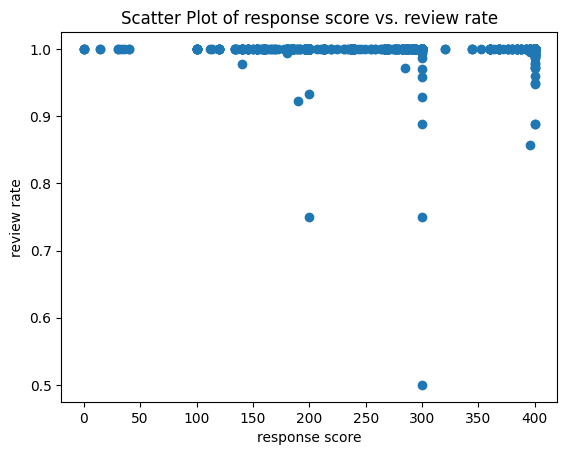

Table that shows total turnover and response score for each listing


+--------+--------------+--------------+
|      id|total_turnover|response_score|
+--------+--------------+--------------+
| 1628130|      27375000|           300|
| 3351728|      23347500|           300|
| 7982359|      22009500|           288|
| 6598203|      22009500|           288|
|13378987|      21900000|           400|
| 6197950|      21900000|          null|
| 3415245|      21515000|           400|
|13216268|      17600000|           300|
| 6444138|      16823700|           288|
| 9327506|      16425000|           300|
| 3808557|      16425000|          null|
| 7618925|      15875000|           300|
|13744821|      14560000|           320|
| 9709597|      14280000|          null|
| 2592416|      13850000|           120|
|11906382|      13687500|           300|
| 7434871|      13634800|           400|
| 5088560|      13200000|           400|
| 5919529|      13145000|           300|
| 5856633|      12775000|          null|
+--------+--------------+--------------+
only showing top

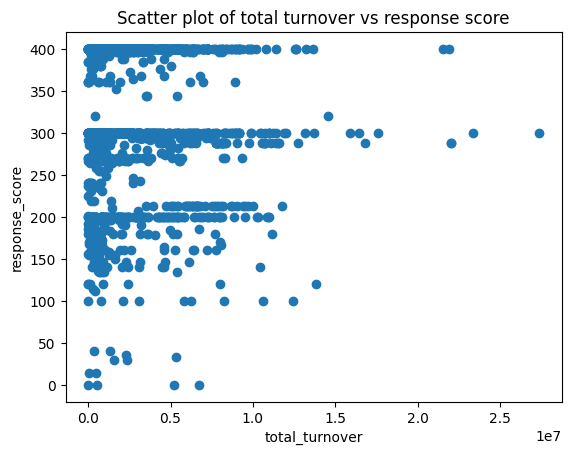

In [61]:
listing_df = listing_df.withColumn("host_response_rate", col("host_response_rate").cast("int"))
listing_df1 = listing_df.withColumn("host_response_time",
                                    when(col("host_response_time") == "within an hour", 4)\
                                        .when(col("host_response_time") == "within a few hours", 3)\
                                            .when(col("host_response_time") == "within a day", 2)\
                                                .when(col("host_response_time") == "a few days or more", 1)\
                                                    .otherwise(0))
#selecting only the relevant columns to calculate response score
listing_df2 = listing_df1.select("id", "host_response_time", "host_response_rate")

#creating new column by multiplying the given metrics
listing_df2 = listing_df2.withColumn("response_score", col("host_response_time")*col("host_response_rate"))
#removing irrelevant columns
listing_df2 = listing_df2.drop('host_response_time', 'host_response_rate')

#joining the table further to perform analysis
final_rr = listing_df2.join(final_review, listing_df2["id"] == final_review["listing_id"])

#dropping redundant column
final_rr = final_rr.drop('listing_id')

print("Table that shows response time score and reviews:")
final_rr.show()

#finding the correlation between response score and review rate
correlation_coefficient = final_rr.select(corr("response_score", "Review_rate")).collect()[0][0]
print("Correlation Coefficient:", correlation_coefficient)

print("The key takeaway from this is that, apart from response score other factors affect the review rate as well. Such as cleaniness, price point, amneties, etc.")

#to plot the response score and review rate we use matplotlib. Thus we convert the spark df to pandas df
pandas_df = final_rr.select("response_score", "Review_rate").toPandas()

plt.scatter(pandas_df["response_score"], pandas_df["Review_rate"])
plt.xlabel("response score")
plt.ylabel("review rate")
plt.title("Scatter Plot of response score vs. review rate")
plt.show()

#dropping irrelevant columns
calendar_2 = calendar_1.drop('booked_days_vec')
list1 = listing_df.withColumn('price', col("price").cast("int"))
#performing initial join
ini_rr = list1.join(final_rr, "id").select("id", "response_score", "price")

#joining remaining final table
fin_rr = ini_rr.join(calendar_2, ini_rr["id"] == calendar_2["listing_id"]).select("id", "response_score", "price", "booked_days")

#calculate total turnover
fin_rr = fin_rr.withColumn("total_turnover", col("price")*col("booked_days"))

#selecting only the relevant columns
vis = fin_rr.select("id", "total_turnover", "response_score")

vis = vis.orderBy(col("total_turnover").desc(), col("response_score").desc())



print("Table that shows total turnover and response score for each listing")
vis.show()

pandas_df1 = vis.select("total_turnover", "response_score").toPandas()
plt.scatter(pandas_df1["total_turnover"], pandas_df1["response_score"])
plt.xlabel("total_turnover")
plt.ylabel("response_score")
plt.title("Scatter plot of total turnover vs response score")
plt.show()

#pushing the results back to a new database in postgres
final_rr.write.format('jdbc').options(url='jdbc:postgresql://localhost:5432/Result',driver = 'org.postgresql.Driver', dbtable = 'response_review', user=config['postgres']["user"],password=config['postgres']["password"]).mode('overwrite').save()
vis.write.format('jdbc').options(url='jdbc:postgresql://localhost:5432/Result',driver = 'org.postgresql.Driver', dbtable = 'vis_rr_turnover', user=config['postgres']["user"],password=config['postgres']["password"]).mode('overwrite').save()